<a href="https://colab.research.google.com/github/yodhasu/Research-Method-Semester-4/blob/main/ResearchMethod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EDA

## import necessary library

In [ ]:
%pip install pmdarima
%pip install prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn import metrics
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA as arima
from statsmodels.tsa.api import VAR
from prophet import Prophet as P
import numpy as np

import warnings
warnings.filterwarnings('ignore')

## Import dataset

Dataset taken from: https://www.kaggle.com/datasets/yasirabd/aqi-jakarta-hanoi-bangkok-kuala-lumpur?select=jakarta-central+%28us+consulate%29+indonesia-air-quality.csv

In [ ]:
df = pd.read_csv('jakarta-central (us consulate) indonesia-air-quality.csv', parse_dates=True)
df[' pm25']= df[' pm25'].str.strip(' ')

df.columns=['date', 'pm25', 'pm10']

## Understand the data

In [ ]:
df = df.drop('pm10', axis = 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1833 entries, 0 to 1832
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1833 non-null   object
 1   pm25    1833 non-null   object
dtypes: object(2)
memory usage: 28.8+ KB


In [ ]:
df.describe()

,date,pm25
count,1833,1833
unique,1833,149
top,2020/12/1,
freq,1,130


In [ ]:
df['pm25'].isna().value_counts()

pm25
False    1833
Name: count, dtype: int64

#Preprocessing

## change dtype

In [ ]:
# df['pm25']= df['pm25'].str.strip()
df['pm25'] = pd.to_numeric(df['pm25'])
df['date'] = pd.to_datetime(df['date'])
# df = df.set_index('date', inplace=True)
# print(df)

In [ ]:
df.isna().value_counts()

date   pm25 
False  False    1703
       True      130
Name: count, dtype: int64

In [ ]:
# df['pm25'] = df['pm25'].fillna(df['pm25'].mean())
df['pm25'] = df['pm25'].ffill()
df = df.set_index('date').sort_index(ascending= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1833 entries, 2015-07-16 to 2020-12-07
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pm25    1833 non-null   float64
dtypes: float64(1)
memory usage: 28.6 KB


<Axes: >

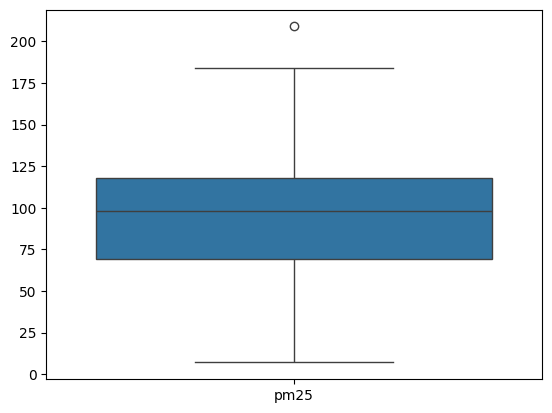

In [ ]:
sb.boxplot(df)

<Axes: xlabel='pm25', ylabel='Density'>

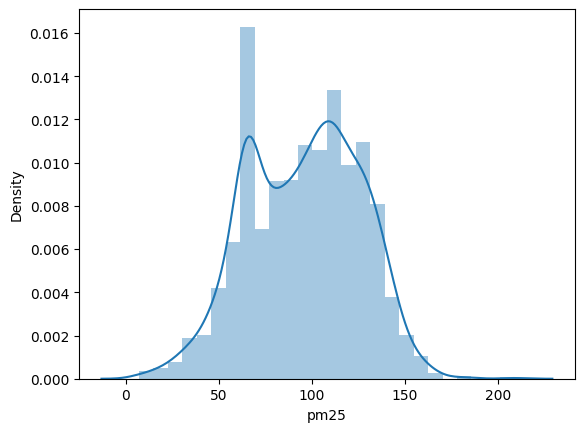

In [ ]:
sb.distplot(df['pm25'])

<Axes: xlabel='date'>

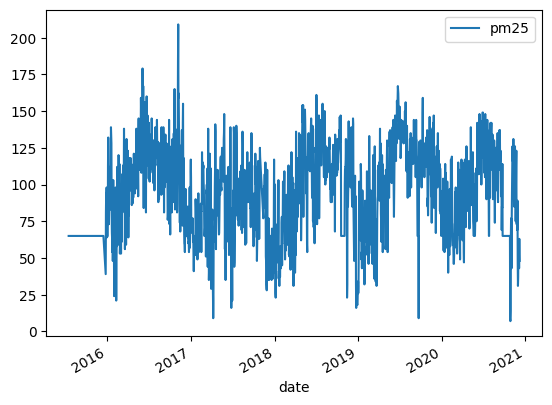

In [ ]:
df.plot()

In [ ]:
df['pm25'].unique()

array([ 65.,  39.,  81.,  94.,  91.,  98.,  64., 113., 132., 109.,  97.,
        73.,  87., 103., 112., 100.,  90.,  83., 121., 139., 134., 128.,
        67.,  63.,  54.,  48.,  62.,  72.,  82.,  46.,  24.,  41.,  53.,
        49.,  66.,  45.,  21.,  61.,  58.,  96.,  68.,  59., 104., 120.,
       119.,  85., 114.,  78.,  69., 107., 105., 101., 111., 138.,  56.,
        89., 131.,  99.,  76.,  95., 115., 123., 108.,  88.,  79.,  93.,
       118., 116., 106.,  86.,  92., 110., 117., 145., 126., 136., 142.,
       130., 122., 159., 147., 124., 125., 179., 156., 137., 167., 133.,
        84., 150., 140., 127., 135., 160., 102., 144., 129., 165., 149.,
       184., 209., 162., 143.,  74., 155.,  60.,  71.,  77.,  70.,  57.,
        75.,  52.,  80.,  55.,  51.,  44.,  35.,  42.,  29.,  31.,  50.,
        37.,   9., 141., 148.,  16.,  47.,  32.,  28.,  43.,  36.,  40.,
        26.,  23., 154., 151., 161., 153., 146.,  33.,  19.,  18.,  34.,
       157., 158., 164.,   7.,  14.])

<Axes: xlabel='date'>

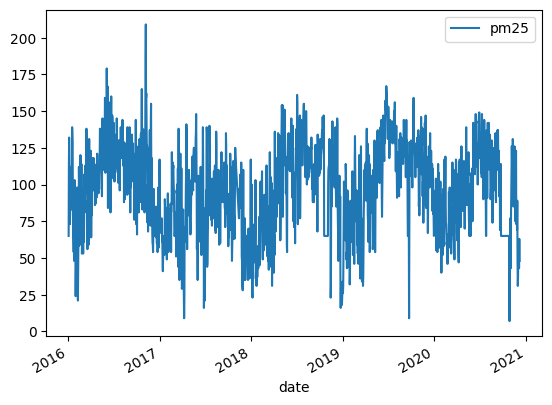

In [ ]:
df = df.iloc[75:]
df.plot()

## Adfuller

In [ ]:
from statsmodels.tsa.stattools import adfuller


result = adfuller(df['pm25'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.909427237060945
n_lags: 3.34303968910881e-05
p-value: 3.34303968910881e-05
Critial Values:
   1%, -3.4341051325206884
Critial Values:
   5%, -2.8631986817182886
Critial Values:
   10%, -2.567653033638267


p value less than 0.005 means that we can reject the null hypotesis in other word the data is stationery

## Train Validate test split

Split into train, validate, test

In [ ]:
X = df.values
size = int(len(df) * 0.7)
train, test = X[0:size], X[size:len(df)]
sizeval = int(len(train) * 0.8)
base_train, val = train[0:sizeval], train[sizeval:len(train)]

traindf = pd.DataFrame(train)
testdf = pd.DataFrame(test)
base_traindf = pd.DataFrame(base_train)
valdf = pd.DataFrame(val)

traindf.index = df.iloc[0:size].index
testdf.index = df.iloc[size:len(df)].index
base_traindf.index = traindf.iloc[0:sizeval].index
valdf.index = traindf.iloc[sizeval:len(train)].index

print(len(base_train), len(val), len(train))

984 246 1230


# Base Model training

## ARIMA

### Auto model to determine (p, d, q)

In [ ]:
stepwise_model = pm.auto_arima(base_train, trace=True, suppress_warnings=True, start_p=0, start_q=0, max_order=4, test = 'adf', seasonal=True)
base_order = stepwise_model.order
base_seasonal = stepwise_model.seasonal_order

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=9513.019, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8795.984, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=9066.692, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11871.941, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=8779.641, Time=0.82 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=8754.960, Time=1.66 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=8750.589, Time=2.12 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=8745.175, Time=2.34 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=8711.495, Time=6.46 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=8708.434, Time=6.99 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=8705.834, Time=5.35 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8704.363, Time=3.88 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8763.940, Time=2.18 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8706.424, Time=5.60 sec
 ARIMA(1,0,2)(0,0,0)[0] intercep

### Model Training

In [ ]:
# model_ar = arima(base_train, order = base_order, seasonal_order=base_seasonal)
# base_fit = model_ar.fit()

In [ ]:
history = [x for x in base_train]

for t in range(int(len(val))):
  model = arima(history, order=base_order, seasonal_order= base_seasonal)
  model_fit = model.fit()
  output = model_fit.forecast(steps=6)
  yhat = output[0]
  obs = test[t]
  history.append(obs)
  print('predicted=%f, expected=%f' % (yhat, obs))

predicted=124.681074, expected=162.000000
predicted=142.422488, expected=154.000000
predicted=139.556215, expected=144.000000
predicted=135.295929, expected=136.000000
predicted=131.601388, expected=131.000000
predicted=129.262416, expected=143.000000
predicted=135.590606, expected=153.000000
predicted=141.345220, expected=148.000000
predicted=139.506724, expected=137.000000
predicted=134.197343, expected=141.000000
predicted=136.361391, expected=118.000000
predicted=124.340827, expected=121.000000
predicted=125.182453, expected=136.000000
predicted=132.432552, expected=144.000000
predicted=136.919675, expected=129.000000
predicted=129.382804, expected=129.000000
predicted=129.156442, expected=137.000000
predicted=133.185104, expected=141.000000
predicted=135.441190, expected=136.000000
predicted=132.927318, expected=132.000000
predicted=131.015882, expected=143.000000
predicted=136.736135, expected=143.000000
predicted=137.081944, expected=132.000000
predicted=131.569615, expected=128

### Make Prediction

In [ ]:
yhat_valid_arima = model_fit.predict(start= 1, end= len(traindf), typ= 'levels')
yhat_valid_arima
yhat_valid_arimadf = pd.DataFrame(yhat_valid_arima)
yhat_valid_arimadf.columns =['yhat_arima']
yhat_valid_arimadf.index = traindf.index
yhat_valid_arimadf

,yhat_arima
date,
2016-01-03,73.832028
2016-01-04,102.205788
2016-01-05,115.216804
2016-01-06,103.979192
2016-01-07,97.696349
...,...
2019-06-21,60.257380
2019-06-22,62.456181
2019-06-23,69.241157


### Compare with validate

In [ ]:
valdf

,0
date,
2018-10-17,147.0
2018-10-18,136.0
2018-10-19,65.0
2018-10-22,65.0
2018-10-23,65.0
...,...
2019-06-21,151.0
2019-06-22,154.0
2019-06-23,158.0


<Axes: xlabel='date'>

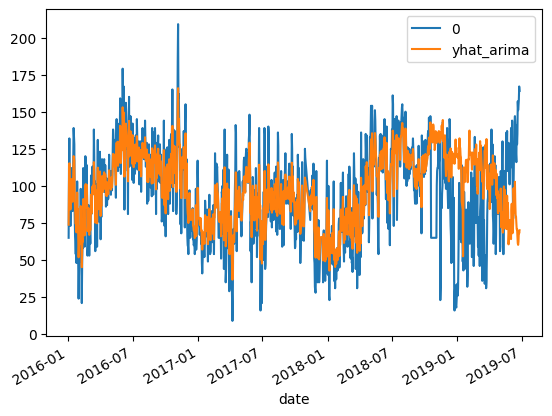

In [ ]:
pd.concat([traindf, yhat_valid_arimadf], axis= 1).plot()

In [ ]:
metrics.mean_squared_error(traindf, yhat_valid_arimadf)

538.4397104904406

## Prophet

### Change file column to 'ds' and 'y'

In [ ]:
prophet_df = base_traindf.reset_index()
prophet_df.columns=['ds', 'y']

In [ ]:
prophet_df

,ds,y
0,2016-01-03,65.0
1,2016-01-04,113.0
2,2016-01-05,132.0
3,2016-01-06,109.0
4,2016-01-07,97.0
...,...,...
979,2018-10-12,125.0
980,2018-10-13,146.0
981,2018-10-14,132.0
982,2018-10-15,131.0


### Prophet model training

In [ ]:
base_prop = P()
base_P_fit = base_prop.fit(prophet_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp38q3_b8/viv22rn8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp38q3_b8/6tm88541.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64161', 'data', 'file=/tmp/tmpp38q3_b8/viv22rn8.json', 'init=/tmp/tmpp38q3_b8/6tm88541.json', 'output', 'file=/tmp/tmpp38q3_b8/prophet_modelnlc8v0od/prophet_model-20240622045147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:51:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:51:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Make Future table containing date of prediction

In [ ]:
future = traindf.copy()
future = future.reset_index()
future.columns = ['ds', 'y']
future = future.drop('y', axis=1)
future

,ds
0,2016-01-03
1,2016-01-04
2,2016-01-05
3,2016-01-06
4,2016-01-07
...,...
1225,2019-06-21
1226,2019-06-22
1227,2019-06-23
1228,2019-06-24


### Predict using future

In [ ]:
prop_predict = base_P_fit.predict(future)
print(prop_predict[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

             ds        yhat  yhat_lower  yhat_upper
0    2016-01-03   91.511076   63.254161  119.788788
1    2016-01-04   90.260831   64.068082  117.189088
2    2016-01-05   93.984365   66.709643  120.742353
3    2016-01-06   92.425221   64.264964  119.607114
4    2016-01-07   93.091806   65.864393  121.742794
...         ...         ...         ...         ...
1225 2019-06-21  147.472885  118.324258  176.000497
1226 2019-06-22  146.780728  118.584301  175.858925
1227 2019-06-23  144.060140  116.160130  174.235756
1228 2019-06-24  142.581243  112.269170  170.627097
1229 2019-06-25  146.343168  117.083891  176.070538

[1230 rows x 4 columns]


###Plot prediction compare to future

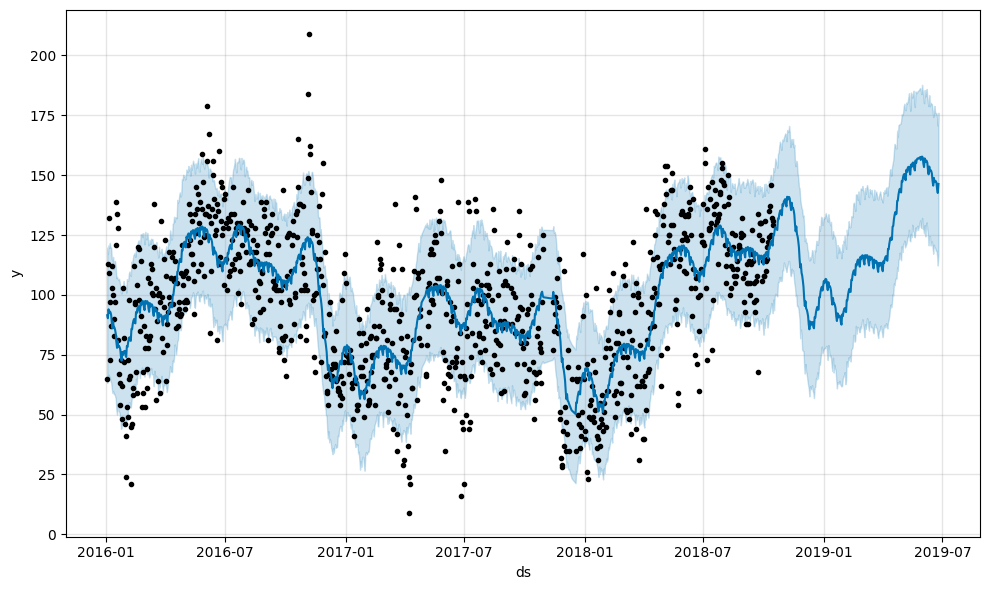

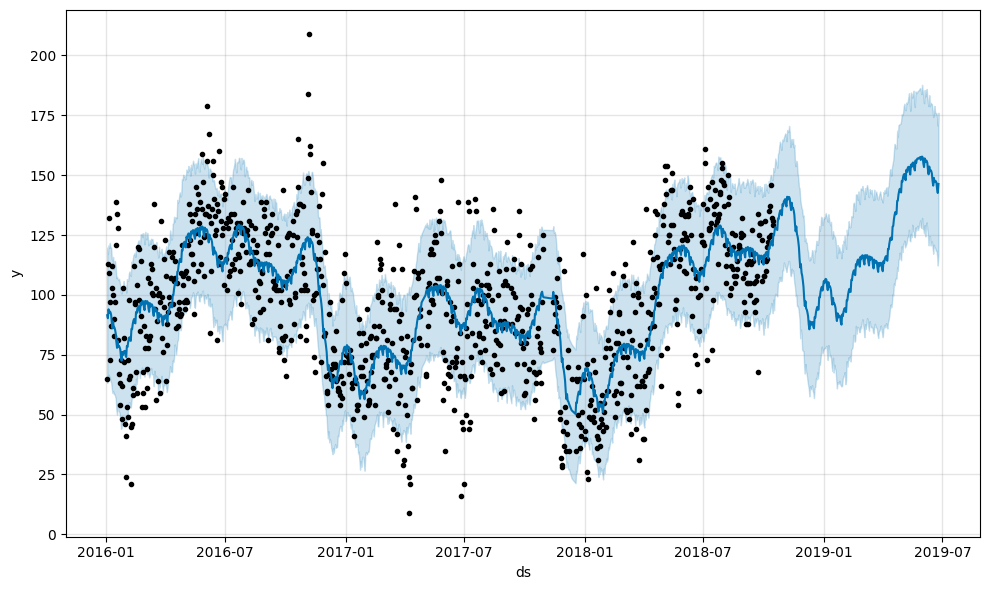

In [ ]:
base_P_fit.plot(prop_predict)

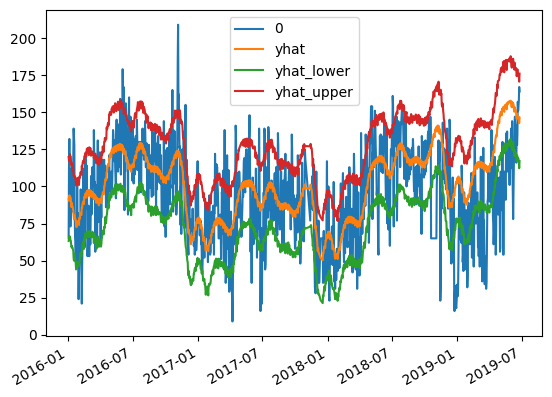

In [ ]:
prop_predict_df = pd.DataFrame(prop_predict[['yhat', 'yhat_lower', 'yhat_upper']]).set_index(prop_predict['ds'])
pd.concat([traindf, prop_predict_df], axis=1).plot()
plt.show()

In [ ]:
metrics.mean_squared_error(traindf, prop_predict_df['yhat'])

759.6467771944709

## MLP

Reference: https://github.com/ruiwu1990/CSCI_4120/blob/master/Neural_network/Time_series_forecasting.ipynb

In [ ]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import optimizers as O
from sklearn import metrics

In [ ]:
# def split_sequences(sequences, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequences)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the dataset
# 		if end_ix > len(sequences):
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)

def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])

    return array(dataX), array(dataY)

In [ ]:
look_back = 1

base_trainx, base_trainy = create_dataset(base_train, look_back)
base_testx, base_testy = create_dataset(val, look_back)

In [ ]:
base_trainx

array([[[ 65.]],

       [[113.]],

       [[132.]],

       [[109.]],

       [[ 97.]],

       [[ 73.]],

       [[ 87.]],

       [[103.]],

       [[112.]],

       [[100.]],

       [[ 90.]],

       [[ 83.]],

       [[ 97.]],

       [[121.]],

       [[139.]],

       [[134.]],

       [[128.]],

       [[ 81.]],

       [[ 67.]],

       [[ 63.]],

       [[ 54.]],

       [[ 73.]],

       [[ 48.]],

       [[ 62.]],

       [[103.]],

       [[ 72.]],

       [[ 82.]],

       [[ 46.]],

       [[ 24.]],

       [[ 41.]],

       [[ 53.]],

       [[ 49.]],

       [[ 73.]],

       [[ 65.]],

       [[ 98.]],

       [[ 66.]],

       [[ 45.]],

       [[ 21.]],

       [[ 46.]],

       [[ 61.]],

       [[ 58.]],

       [[112.]],

       [[ 96.]],

       [[ 97.]],

       [[ 68.]],

       [[ 59.]],

       [[104.]],

       [[120.]],

       [[119.]],

       [[ 98.]],

       [[ 85.]],

       [[114.]],

       [[ 91.]],

       [[ 53.]],

       [[ 59.]],

       [[ 

In [ ]:
base_trainy[1]

array([132.])

In [ ]:
base_model = Sequential()
base_model.add(Dense(20, input_dim=look_back, activation='relu'))
base_model.add(Dense(1))
optim = O.Adam(learning_rate = 0.0001)
base_model.compile(loss='mse', optimizer=optim)

base_model.fit(base_trainx, base_trainy, epochs = 500, shuffle = False, verbose = 1)

Epoch 1/500
31/31 [==============================] - 3s 9ms/step - loss: 5487.4316
Epoch 2/500
31/31 [==============================] - 0s 7ms/step - loss: 5178.6572
Epoch 3/500
31/31 [==============================] - 0s 8ms/step - loss: 4881.2598
Epoch 4/500
31/31 [==============================] - 0s 9ms/step - loss: 4597.1929
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 4326.2598
Epoch 6/500
31/31 [==============================] - 0s 4ms/step - loss: 4068.1470
Epoch 7/500
31/31 [==============================] - 0s 4ms/step - loss: 3822.5376
Epoch 8/500
31/31 [==============================] - 0s 4ms/step - loss: 3589.1157
Epoch 9/500
31/31 [==============================] - 0s 8ms/step - loss: 3367.5649
Epoch 10/500
31/31 [==============================] - 0s 13ms/step - loss: 3157.5674
Epoch 11/500
31/31 [==============================] - 0s 4ms/step - loss: 2958.8059
Epoch 12/500
31/31 [==============================] - 0s 8ms/step - loss: 2770.9617


In [ ]:
base_mlp = base_model.predict(train)
base_mlpdf = pd.DataFrame(base_mlp, columns=['yhat']).set_index(traindf.index)

39/39 [==============================] - 0s 3ms/step


In [ ]:
base_mlp[-2:].shape

(2, 1)

In [ ]:
print(traindf[3:].head())
print(base_mlpdf.head())

                0
date             
2016-01-06  109.0
2016-01-07   97.0
2016-01-08   73.0
2016-01-09   87.0
2016-01-10  103.0
                  yhat
date                  
2016-01-03   65.739906
2016-01-04  109.667732
2016-01-05  127.055847
2016-01-06  106.007088
2016-01-07   95.025124


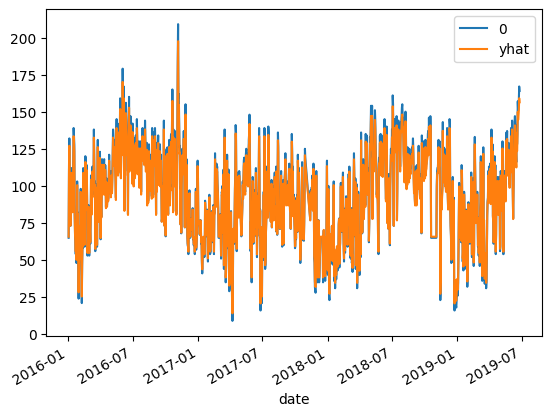

In [ ]:
pd.concat([traindf, base_mlpdf], axis = 1).plot()
plt.legend()

In [ ]:
print(metrics.mean_squared_error(base_train, base_model.predict(base_train)))
print(metrics.mean_squared_error(val, base_model.predict(val)))

31/31 [==============================] - 0s 3ms/step
10.213551988407648
8/8 [==============================] - 0s 5ms/step
9.20563503799087


In [ ]:
metrics.mean_squared_error(train, base_mlp)

10.011968598324293

# Meta model training dataset

In [ ]:
meta_train = pd.concat([traindf, yhat_valid_arimadf, prop_predict_df, base_mlpdf], axis = 1)
meta_train.columns = ['y', 'yhat_arima', 'yhat_prophet', 'yhat_prophet_lower', 'yhat_prophet_upper', 'yhat_mlp']
meta_train

,y,yhat_arima,yhat_prophet,yhat_prophet_lower,yhat_prophet_upper,yhat_mlp
2016-01-03,65.0,73.832028,91.511076,63.254161,119.788788,65.739906
2016-01-04,113.0,102.205788,90.260831,64.068082,117.189088,109.667732
2016-01-05,132.0,115.216804,93.984365,66.709643,120.742353,127.055847
2016-01-06,109.0,103.979192,92.425221,64.264964,119.607114,106.007088
2016-01-07,97.0,97.696349,93.091806,65.864393,121.742794,95.025124
...,...,...,...,...,...,...
2019-06-21,151.0,60.257380,147.472885,118.324258,176.000497,144.443939
2019-06-22,154.0,62.456181,146.780728,118.584301,175.858925,147.189438
2019-06-23,158.0,69.241157,144.060140,116.160130,174.235756,150.850082
2019-06-24,167.0,68.072633,142.581243,112.269170,170.627097,159.086533


# Meta model training

MLP (Multi Layer Perceptron) will be used as the Meta Model

## Preparation

In [ ]:
y_seq = array(meta_train['y'].values)
yhat_arima_seq = array(meta_train['yhat_arima'].values)
yhat_prophet_seq = array(meta_train['yhat_prophet'].values)
yhat_lower_bound = array(meta_train['yhat_prophet_lower'].values)
yhat_upper_bound = array(meta_train['yhat_prophet_upper'].values)
yhat_mlp = array(meta_train['yhat_mlp'].values)
y_real = array(testdf.values)


In [ ]:
y_seq = y_seq.reshape((len(y_seq), 1))
yhat_arima_seq = yhat_arima_seq.reshape((len(yhat_arima_seq), 1))
yhat_prophet_seq = yhat_prophet_seq.reshape((len(yhat_prophet_seq), 1))
yhat_lower_bound = yhat_lower_bound.reshape((len(yhat_lower_bound), 1))
yhat_upper_bound = yhat_upper_bound.reshape((len(yhat_upper_bound), 1))
yhat_mlp = yhat_mlp.reshape((len(yhat_mlp), 1))

In [ ]:
dataset = hstack((y_seq, yhat_arima_seq, yhat_prophet_seq, yhat_lower_bound, yhat_upper_bound, yhat_mlp))

In [ ]:
new_X = hstack((yhat_arima_seq, yhat_prophet_seq, yhat_lower_bound, yhat_upper_bound, yhat_mlp))

In [ ]:
new_X.shape

(1230, 5)

In [ ]:
y_seq.shape

(1230, 1)

In [ ]:
y_real.shape

(528, 1)

In [ ]:
n_steps = new_X.shape[1]
X, y = create_dataset(dataset, n_steps)
x_test, y_test = create_dataset(y_real, n_steps)

In [ ]:
X.shape

(1224, 5, 6)

In [ ]:
# n_input = X.shape[1] * X.shape[2]
# X = X.reshape((X.shape[0], n_input))
# print(X)

## Modeling

In [ ]:
model = Sequential()
# model.add(Dense(10, activation='relu', input_dim= n_steps))

model.add(Dense(1000, activation='relu', input_dim= 5))
model.add(Dense(500, activation='relu', input_dim= 5))
model.add(Dense(250, activation='relu', input_dim= 5))
model.add(Dense(1))
optimz = O.Adam(learning_rate = 0.000001)
model.compile(optimizer= optimz, loss='mse')

model.fit(new_X, y_seq, epochs=500, verbose=1, shuffle=False)

mlp_pred = model.predict(x_test)

metrics.mean_squared_error(test[6:], mlp_pred)

Epoch 1/500
39/39 [==============================] - 4s 19ms/step - loss: 10320.8496
Epoch 2/500
39/39 [==============================] - 1s 23ms/step - loss: 9845.0811
Epoch 3/500
39/39 [==============================] - 1s 22ms/step - loss: 9388.4951
Epoch 4/500
39/39 [==============================] - 1s 26ms/step - loss: 8947.7764
Epoch 5/500
39/39 [==============================] - 1s 21ms/step - loss: 8520.3809
Epoch 6/500
39/39 [==============================] - 1s 19ms/step - loss: 8108.9917
Epoch 7/500
39/39 [==============================] - 1s 21ms/step - loss: 7714.4116
Epoch 8/500
39/39 [==============================] - 1s 20ms/step - loss: 7335.5405
Epoch 9/500
39/39 [==============================] - 1s 24ms/step - loss: 6972.4351
Epoch 10/500
39/39 [==============================] - 1s 22ms/step - loss: 6624.7280
Epoch 11/500
39/39 [==============================] - 1s 21ms/step - loss: 6292.4272
Epoch 12/500
39/39 [==============================] - 1s 22ms/step - loss

610.8232335543105

## Prediction

In [ ]:
metrics.mean_squared_error(test[6:], mlp_pred)

610.8232335543105

In [ ]:
new_mlp_pred = base_model.predict(y_test)

17/17 [==============================] - 0s 2ms/step


In [ ]:
new_mlp_preddf = pd.DataFrame(new_mlp_pred).set_index(testdf.iloc[6:].index)

In [ ]:
mlp_preddf = pd.DataFrame(mlp_pred).set_index(testdf.iloc[6:].index)

In [ ]:
testdf.iloc[:6].head()

,0
date,
2019-06-26,162.0
2019-06-27,154.0
2019-06-28,144.0
2019-06-29,136.0
2019-06-30,131.0


In [ ]:
metrics.mean_squared_error(test[6:], new_mlp_pred)

337.4491664448873

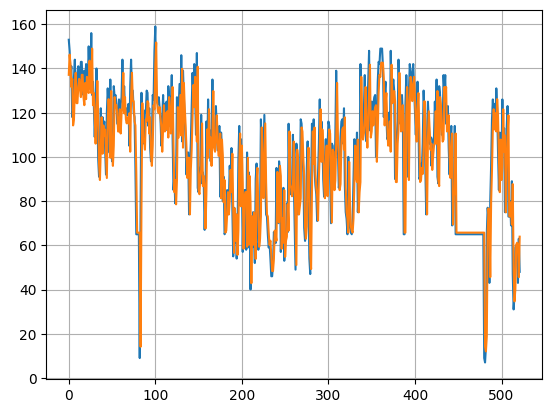

In [ ]:
plt.plot(test[6:])
plt.plot(new_mlp_pred)
plt.grid()
plt.show()

# Evaluation Metrics

## Train base model on train dataset to predict test

### ARIMA

In [ ]:
autoar = pm.auto_arima(train, trace=True, suppress_warnings=True, start_p=0, start_q=0, max_order=4, test = 'adf', seasonal=True)
orders = autoar.order
s_orders = autoar.seasonal_order

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=11929.554, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=10996.238, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=11339.960, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=14811.986, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=10985.254, Time=0.46 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=10960.121, Time=0.60 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=10953.992, Time=0.77 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=10942.532, Time=0.58 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=10915.214, Time=3.67 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=10910.987, Time=4.95 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=10908.253, Time=2.78 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=10911.427, Time=1.91 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=10911.874, Time=2.96 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=10908.022, Time=3.57 sec
 ARIMA(1,0,2)(0,0,0

#### rolling window

In [ ]:
def fit_arima(train, test, order):
    history = list(train)
    predictions = []
    for t in range(len(test)):
        model = arima(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    error = metrics.mean_squared_error(test, predictions)
    return error, predictions

In [ ]:
import time
start = time.time()

history = [x for x in train]
predictions = list()
for t in range(len(test)):
    train_subset = history[-5:]
    error, yhat_sequence = fit_arima(train_subset, [test[t]], orders)
    predictions.append(yhat_sequence[0])
    history.append(test[t])

end = time.time()

arima_process = (end - start)
print(arima_process)
print(len(predictions))

133.58156657218933
528


In [ ]:
# arima_pred = model_fit.predict(start= len(traindf), end= len(df) - 1, typ='levels')
arima_pred_df = pd.DataFrame(predictions, columns=['yhat_arima'])
arima_pred_df.index= testdf.index
arima_pred_df.column = ['yhat_arima']

#### Normal

In [ ]:
yhat = model_fit.predict(start= len(traindf), end= len(df)-1)
arima_pred_df2 = pd.DataFrame(yhat, columns=['yhat_arima'])
arima_pred_df2.index= testdf.index
arima_pred_df2.column = ['yhat_arima']

### Prophet

In [ ]:
df.tail()

,pm25
date,
2020-12-03,60.0
2020-12-04,59.0
2020-12-05,43.0
2020-12-06,63.0
2020-12-07,48.0


In [ ]:
prop_train = traindf.reset_index()
prop_train.columns = ['ds', 'y']

In [ ]:
model_p = P()
model_p_fit = model_p.fit(prop_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp38q3_b8/mtay_mxj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp38q3_b8/xjb3ndny.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84564', 'data', 'file=/tmp/tmpp38q3_b8/mtay_mxj.json', 'init=/tmp/tmpp38q3_b8/xjb3ndny.json', 'output', 'file=/tmp/tmpp38q3_b8/prophet_modelw56rurfe/prophet_model-20240622062653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:26:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:26:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = testdf.reset_index()
future.columns = ['ds', 'y']
future = future.drop('y', axis=1)
future

,ds
0,2019-06-26
1,2019-06-27
2,2019-06-28
3,2019-06-29
4,2019-06-30
...,...
523,2020-12-03
524,2020-12-04
525,2020-12-05
526,2020-12-06


In [ ]:
prop_test = model_p_fit.predict(future)

In [ ]:
prop_test

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-06-26,100.305338,82.689908,143.219740,100.305338,100.305338,13.858662,13.858662,13.858662,0.062822,0.062822,0.062822,13.795840,13.795840,13.795840,0.0,0.0,0.0,114.164000
1,2019-06-27,100.313881,85.325295,144.822655,100.313881,100.313881,13.270922,13.270922,13.270922,-0.205407,-0.205407,-0.205407,13.476329,13.476329,13.476329,0.0,0.0,0.0,113.584803
2,2019-06-28,100.322424,82.976637,142.186482,100.322424,100.322424,13.353823,13.353823,13.353823,0.134048,0.134048,0.134048,13.219774,13.219774,13.219774,0.0,0.0,0.0,113.676247
3,2019-06-29,100.330967,85.275445,143.067815,100.330967,100.330967,13.275820,13.275820,13.275820,0.241995,0.241995,0.241995,13.033824,13.033824,13.033824,0.0,0.0,0.0,113.606787
4,2019-06-30,100.339510,82.770943,142.718492,100.339510,100.339510,12.431197,12.431197,12.431197,-0.493855,-0.493855,-0.493855,12.925052,12.925052,12.925052,0.0,0.0,0.0,112.770708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,2020-12-03,104.798983,59.075097,127.605219,88.355510,119.338536,-9.955138,-9.955138,-9.955138,-0.205407,-0.205407,-0.205407,-9.749731,-9.749731,-9.749731,0.0,0.0,0.0,94.843845
524,2020-12-04,104.807527,58.690086,127.558904,88.327726,119.373623,-11.613436,-11.613436,-11.613436,0.134048,0.134048,0.134048,-11.747485,-11.747485,-11.747485,0.0,0.0,0.0,93.194090
525,2020-12-05,104.816070,57.341804,122.797540,88.299942,119.454614,-13.515127,-13.515127,-13.515127,0.241995,0.241995,0.241995,-13.757122,-13.757122,-13.757122,0.0,0.0,0.0,91.300943
526,2020-12-06,104.824613,54.143735,120.846798,88.272158,119.516683,-16.252270,-16.252270,-16.252270,-0.493855,-0.493855,-0.493855,-15.758416,-15.758416,-15.758416,0.0,0.0,0.0,88.572342


In [ ]:
prop_test['yhat']

0      114.164000
1      113.584803
2      113.676247
3      113.606787
4      112.770708
          ...    
523     94.843845
524     93.194090
525     91.300943
526     88.572342
527     86.132018
Name: yhat, Length: 528, dtype: float64

### MLP

In [ ]:
mlp_mod = base_model.predict(test)
mlp_moddf = pd.DataFrame(mlp_mod, columns=['yhat']).set_index(testdf.index)

17/17 [==============================] - 0s 2ms/step


<Axes: xlabel='date'>

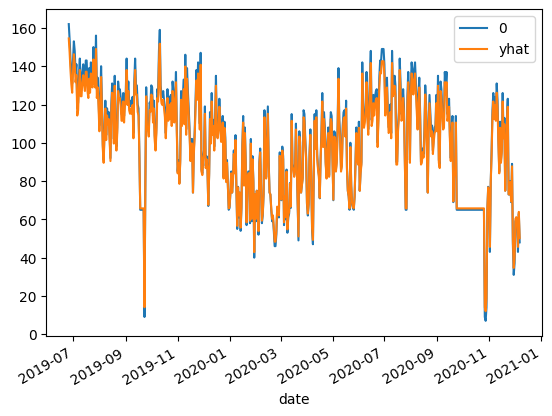

In [ ]:
pd.concat([testdf, mlp_moddf], axis= 1).plot()

## Evaluate

In [ ]:
# ARIMA wih rolling window
from math import sqrt
arima_mae = metrics.mean_absolute_error(testdf, predictions)
arima_mse = metrics.mean_squared_error(testdf, predictions)
arima_rmse = sqrt(arima_mse)
arima_r2 = metrics.r2_score(testdf, predictions)

print('Arima Model - MAE: %f | MSE: %f | RMSE: %f | R2 score: %f' % (arima_mae, arima_mse, arima_rmse, arima_r2))

Arima Model - MAE: 18.612133 | MSE: 618.754973 | RMSE: 24.874786 | R2 score: 0.214006


<Axes: xlabel='date'>

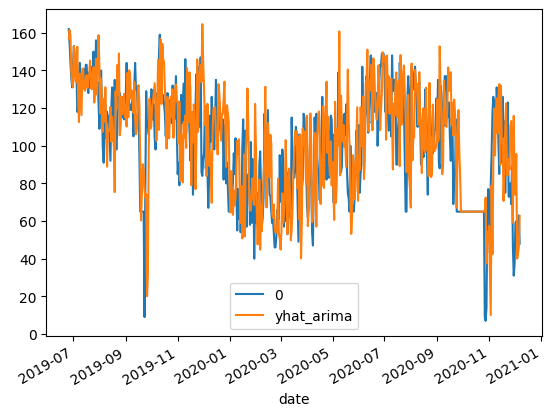

In [ ]:
pd.concat([testdf, arima_pred_df], axis= 1).plot()

Arima Model - MAE: 27.113897 | MSE: 1039.831934 | RMSE: 32.246425 | R2 score: -0.320881


<Axes: xlabel='date'>

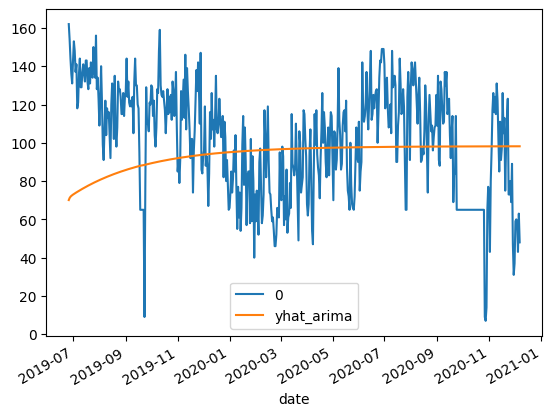

In [ ]:
# ARIMA without rolling window

arima_mae2 = metrics.mean_absolute_error(testdf, yhat)
arima_mse2 = metrics.mean_squared_error(testdf, yhat)
arima_rmse2 = sqrt(arima_mse2)
arima2_r2 = metrics.r2_score(testdf, yhat)

print('Arima Model - MAE: %f | MSE: %f | RMSE: %f | R2 score: %f' % (arima_mae2, arima_mse2, arima_rmse2, arima2_r2))

pd.concat([testdf, arima_pred_df2], axis= 1).plot()

In [ ]:
prophet_mae = metrics.mean_absolute_error(testdf, prop_test['yhat'])
prophet_mse = metrics.mean_squared_error(testdf, prop_test['yhat'])
prophet_rmse = sqrt(prophet_mse)
prophet_r2 = metrics.r2_score(testdf, prop_test['yhat'])

print('Prophet Model - MAE: %f | MSE: %f | RMSE: %f | R2 Score: %f' % (prophet_mae, prophet_mse, prophet_rmse, prophet_r2))

Prophet Model - MAE: 20.522760 | MSE: 706.356276 | RMSE: 26.577364 | R2 Score: 0.102727


Even though the overall score of Prophet model is lower than ARIMA, Prophet model also predict the upper and lower bound of it's prediction

<Axes: >

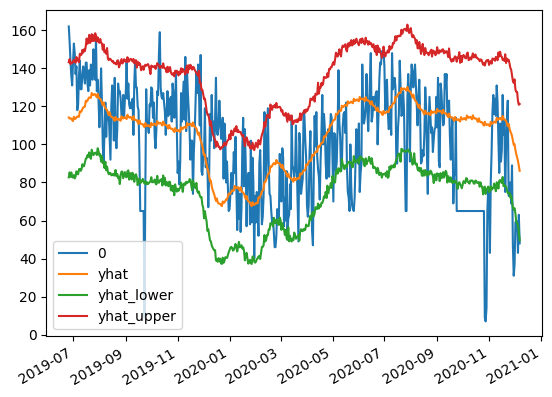

In [ ]:
prop_test_df = pd.DataFrame(prop_test[['yhat', 'yhat_lower', 'yhat_upper']]).set_index(prop_test['ds'])
pd.concat([testdf, prop_test_df], axis=1).plot()

Count predicted inside the bounds

In [ ]:
prophet_insidebound = list()
upper = [x for x in prop_test['yhat_upper']]
lower = [x for x in prop_test['yhat_lower']]
obj = [x for x in testdf]

for i in range(len(testdf)):
  if (test[i] <= upper[i]) and (test[i] >= lower[i]):
    prophet_insidebound.append(1)
  else:
    prophet_insidebound.append(0)

In [ ]:
print(prophet_insidebound.count(1))
print(prophet_insidebound.count(0))

404
124


435 data is inside the bounds

In [ ]:
percentage = 100* (prophet_insidebound.count(1) / len(test))
percentage

76.51515151515152

this shows that even though the overall score of Pohet model prediction is low but arround 75% of the data is inside the bounds, thus making it considered as a good model

In [ ]:
# MLP

mlp_mse = metrics.mean_squared_error(testdf, mlp_moddf)
mlp_mae = metrics.mean_absolute_error(testdf, mlp_moddf)
mlp_rmse = sqrt(mlp_mse)
mlp_r2 = metrics.r2_score(testdf, mlp_moddf)

print('MLP Model - MAE: %f | MSE: %f | RMSE: %f | R2 score: %f' % (mlp_mae, mlp_mse, mlp_rmse, mlp_r2))

MLP Model - MAE: 2.821212 | MSE: 11.130386 | RMSE: 3.336223 | R2 score: 0.985861


<Axes: xlabel='date'>

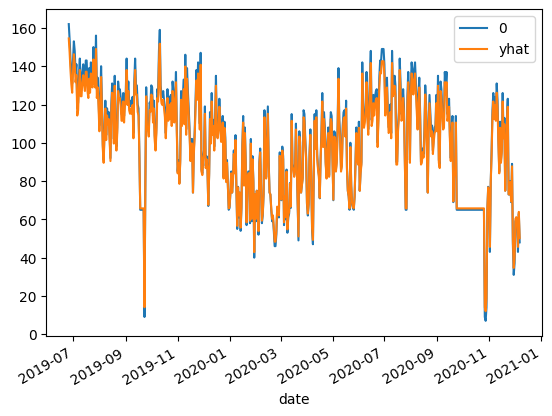

In [ ]:
pd.concat([testdf, mlp_moddf], axis = 1).plot()

In [ ]:
# Meta Model
meta_mae = metrics.mean_absolute_error(testdf.iloc[6:], mlp_preddf)
meta_mse = metrics.mean_squared_error(testdf.iloc[6:], mlp_preddf)
meta_rmse = sqrt(meta_mse)
meta_r2 = metrics.r2_score(testdf.iloc[6:], mlp_preddf)

print('Meta MLP Model - MAE: %f | MSE: %f | RMSE: %f | R2 score: %f' % (meta_mae, meta_mse, meta_rmse, meta_r2))

Meta MLP Model - MAE: 18.979629 | MSE: 610.823234 | RMSE: 24.714838 | R2 score: 0.209681


<Axes: xlabel='date'>

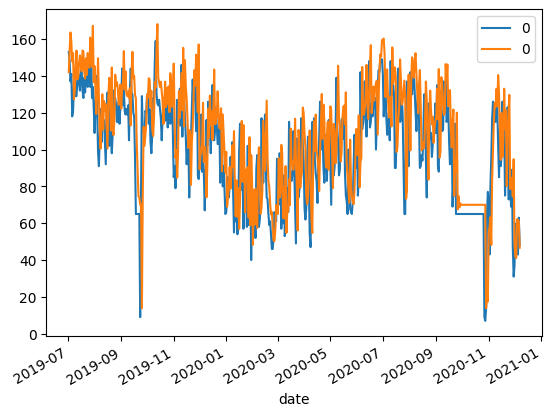

In [ ]:
pd.concat([testdf.iloc[6:], mlp_preddf], axis = 1).plot()

# Save models

In [ ]:
%pip install --upgrade keras
%pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 31.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 68.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency res

In [ ]:
%pip install --upgrade tf-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.9 MB/s eta 0:00:00
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.15.1
    Uninstalling tf_keras-2.15.1:
      Successfully uninstalled tf_keras-2.15.1


In [ ]:
from statsmodels.tsa.arima.model import ARIMAResults

model_fit.save("trained_arima.pkl")

In [ ]:
from prophet.serialize import model_to_json, model_from_json

with open('prophet_model.json', 'w') as fout:
    fout.write(model_to_json(model_p))  # Save model

In [ ]:
import keras

keras.saving.save_model(base_model, './new_mlp_base2.keras', overwrite=True)

In [ ]:
%cd /content/

/content


In [ ]:
!zip -r my_models.zip my_models/

	zip warning: name not matched: my_models/

zip error: Nothing to do! (try: zip -r my_models.zip . -i my_models/)


In [ ]:
keras.__version__

'2.15.0'

In [ ]:
import tensorflow as ts

ts.version.VERSION

'2.15.0'

In [ ]:
tryarr= mlp_mod

In [ ]:
tryarr

array([[154.51074 ],
       [147.18944 ],
       [138.03781 ],
       [130.71649 ],
       [126.14066 ],
       [137.12265 ],
       [146.27428 ],
       [141.69844 ],
       [131.63167 ],
       [135.29231 ],
       [114.243546],
       [116.989044],
       [130.71649 ],
       [138.03781 ],
       [124.31034 ],
       [124.31034 ],
       [131.63167 ],
       [135.29231 ],
       [130.71649 ],
       [127.05585 ],
       [137.12265 ],
       [137.12265 ],
       [127.05585 ],
       [123.39517 ],
       [133.46198 ],
       [126.14066 ],
       [136.20747 ],
       [129.80133 ],
       [128.88615 ],
       [143.52878 ],
       [132.54683 ],
       [128.88615 ],
       [149.01974 ],
       [123.39517 ],
       [128.88615 ],
       [118.81937 ],
       [106.00709 ],
       [117.9042  ],
       [134.37715 ],
       [117.9042  ],
       [ 96.85545 ],
       [ 89.53414 ],
       [104.17676 ],
       [117.9042  ],
       [101.43127 ],
       [114.243546],
       [109.66773 ],
       [112.4

In [ ]:
import numpy
future = mlp_mod[-1:]
# future = numpy.append(future, mlp_mod[-2:], axis = 0)
print(future)
print(mlp_mod[-2:])

[[50.18212]]
[[63.909573]
 [50.18212 ]]


In [ ]:

for i in range(60):
  pred = base_model.predict(future[-1:])
  future = numpy.append(future, pred, axis = 0)

print(future)

1/1 [==============================] - 0s 26ms/step
[[50.18212 ]
 [52.179123]
 [54.006702]
 [55.67924 ]
 [57.20989 ]
 [58.610672]
 [59.892624]
 [61.065815]
 [62.139473]
 [63.122044]
 [64.02127 ]
 [64.84421 ]
 [65.59733 ]
 [66.28655 ]
 [66.9173  ]
 [67.49454 ]
 [68.022804]
 [68.506256]
 [68.94869 ]
 [69.35359 ]
 [69.72415 ]
 [70.06327 ]
 [70.37363 ]
 [70.657646]
 [70.91757 ]
 [71.15545 ]
 [71.373146]
 [71.57237 ]
 [71.7547  ]
 [71.92155 ]
 [72.07425 ]
 [72.214   ]
 [72.34188 ]
 [72.458916]
 [72.56604 ]
 [72.66406 ]
 [72.75376 ]
 [72.83585 ]
 [72.91097 ]
 [72.97974 ]
 [73.042656]
 [73.10024 ]
 [73.15295 ]
 [73.201164]
 [73.24529 ]
 [73.285675]
 [73.322655]
 [73.35649 ]
 [73.38745 ]
 [73.415794]
 [73.44172 ]
 [73.46545 ]
 [73.487175]
 [73.50706 ]
 [73.52525 ]
 [73.54189 ]
 [73.55713 ]
 [73.571075]
 [73.58384 ]
 [73.595505]
 [73.606186]]


In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [ ]:
steps = 3
dataset = train

new_x, new_y = split_sequence(dataset, steps, 1)

In [ ]:
train[-3:]

array([[158.],
       [167.],
       [164.]])

In [ ]:
print(new_x[[-1]], new_y[-1])

[[[154.]
  [158.]
  [167.]]] [[164.]]


In [ ]:
new_x[-1]

array([[154.],
       [158.],
       [167.]])

In [ ]:
new_y.shape

(1227, 1, 1)

In [ ]:
multi = Sequential()
multi.add(Dense(50, input_dim=steps, activation='relu'))
multi.add(Dense(100, activation='relu'))
multi.add(Dense(1))
optim = O.Adam(learning_rate=0.00001)
multi.compile(loss='mse', optimizer=optim)

multi.fit(new_x, new_y, epochs = 1500, shuffle = False, verbose = 1)

Epoch 1/1500
39/39 [==============================] - 1s 3ms/step - loss: 11268.3994
Epoch 2/1500
39/39 [==============================] - 0s 3ms/step - loss: 10885.6113
Epoch 3/1500
39/39 [==============================] - 0s 2ms/step - loss: 10512.4951
Epoch 4/1500
39/39 [==============================] - 0s 5ms/step - loss: 10149.8789
Epoch 5/1500
39/39 [==============================] - 0s 5ms/step - loss: 9796.8828
Epoch 6/1500
39/39 [==============================] - 0s 5ms/step - loss: 9453.0400
Epoch 7/1500
39/39 [==============================] - 0s 4ms/step - loss: 9117.7500
Epoch 8/1500
39/39 [==============================] - 0s 7ms/step - loss: 8790.1494
Epoch 9/1500
39/39 [==============================] - 0s 4ms/step - loss: 8468.6016
Epoch 10/1500
39/39 [==============================] - 0s 4ms/step - loss: 8151.2061
Epoch 11/1500
39/39 [==============================] - 0s 3ms/step - loss: 7836.9072
Epoch 12/1500
39/39 [==============================] - 0s 3ms/step - l

In [ ]:
multi.predict(array([[154, 158, 167]]))

1/1 [==============================] - 0s 99ms/step


array([[159.03357]], dtype=float32)

In [ ]:
new_y

array([[[109.]],

       [[ 97.]],

       [[ 73.]],

       ...,

       [[158.]],

       [[167.]],

       [[164.]]])

In [ ]:
arr = numpy.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [ ]:
arr.shape

In [ ]:
newarr1, newarr2 = split_sequence(arr, 3, 1)

In [ ]:
testx.shape

In [ ]:
datset = test[-4:]

In [ ]:
datset = numpy.append(datset, [[69]], axis=0)

In [ ]:
datset

In [ ]:
# pred = multi.predict(testx)
import numpy
pred = []

hist = test[-4:]
for i in range(5):
  newx, newy = split_sequence(hist, 3, 1)
  future = multi.predict(newx[-1:])
  pred.append(future)
  hist = numpy.append(hist, future, axis = 0)
  time.sleep(3)
  future = None
  print(hist)

In [ ]:
import numpy as np

step_n = 10
steps = np.random.choice([-1, 0, 1], size=(1,2))
for n in range(step_n-1):
    step = np.random.choice([-1, 0, 1], size=(1,2))
    print(steps)
    steps = np.append(steps, step, axis=0)
    #something will be checked after each n

print(steps)

In [ ]:
numpy.append(hist, future)

In [ ]:
pred = numpy.array(pred)

In [ ]:
pred

In [ ]:
preddf = pd.DataFrame(pred)

In [ ]:
plt.plot(test)
plt.plot(pred)

In [ ]:
keras.saving.save_model(filepath="./new_model/multistep_mlp.keras", model = multi)

In [ ]:
trydat = [1, 2, 3, 4]

trydf = pd.DataFrame(trydat)
trydf